In [1]:
# For processing the data
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline
sns.set_style("white") # set style for seaborn plots

# Machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2, SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, VotingClassifier, 
                              RandomForestClassifier, AdaBoostClassifier)
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv("data.csv")
data = pd.DataFrame(data)
data = data.set_index('shot_id')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [4]:
irrelevant = ["lon", "lat", "team_id", "team_name", "game_id", "game_event_id", "game_date"]
data = data.drop(columns=irrelevant)
data

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,167,72,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30693,Jump Shot,Jump Shot,1,48,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND
30694,Tip Shot,Tip Shot,0,0,6,4,1,1999-00,5,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND
30695,Running Jump Shot,Jump Shot,-134,166,3,4,1,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND


In [5]:
tr = data

In [6]:
tr_labels = data["shot_made_flag"]
tr_labels = tr_labels.dropna()
tr_labels

shot_id
2        0.0
3        1.0
4        0.0
5        1.0
6        0.0
        ... 
30692    0.0
30693    0.0
30695    1.0
30696    0.0
30697    0.0
Name: shot_made_flag, Length: 25697, dtype: float64

In [7]:
tr_num = tr.select_dtypes(include='int64')
tr_num

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance
shot_id,,,,,,,
1,167,72,10,1,0,27,18
2,-157,0,10,1,0,22,15
3,-101,135,7,1,0,45,16
4,138,175,6,1,0,52,22
5,0,0,6,2,0,19,0
...,...,...,...,...,...,...,...
30693,1,48,6,4,1,5,4
30694,0,0,6,4,1,5,0
30695,-134,166,3,4,1,28,21


In [8]:
tr_cat = tr.select_dtypes(include='object')
tr_cat

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,
1,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,LAL @ POR,POR
2,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR
3,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR
4,Jump Shot,Jump Shot,2000-01,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...
30693,Jump Shot,Jump Shot,1999-00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND
30694,Tip Shot,Tip Shot,1999-00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,LAL vs. IND,IND
30695,Running Jump Shot,Jump Shot,1999-00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL vs. IND,IND


In [9]:
le = LabelEncoder()

In [10]:
# Turning string data into numbers
tr["action_type"] = le.fit_transform(tr["action_type"])
tr["season"] = le.fit_transform(tr["season"])
tr["combined_shot_type"] = le.fit_transform(tr["combined_shot_type"])
tr["shot_type"] = le.fit_transform(tr["shot_type"])
tr["shot_zone_area"] = le.fit_transform(tr["shot_zone_area"])
tr["shot_zone_basic"] = le.fit_transform(tr["shot_zone_basic"])
tr["shot_zone_range"] = le.fit_transform(tr["shot_zone_range"])
tr["matchup"] = le.fit_transform(tr["matchup"])
tr["opponent"] = le.fit_transform(tr["opponent"])

In [11]:
tr.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,
1,26,3,167,72,10,1,0,4,27,18,NaN,0,5,4,0,28,25
2,26,3,-157,0,10,1,0,4,22,15,0.0,0,3,4,2,28,25
3,26,3,-101,135,7,1,0,4,45,16,1.0,0,2,4,0,28,25
4,26,3,138,175,6,1,0,4,52,22,0.0,0,4,4,0,28,25
5,5,1,0,0,6,2,0,4,19,0,1.0,0,1,5,4,28,25


In [12]:
tr_data = tr.dropna()

In [13]:
target_values = tr_data['shot_made_flag'].values

In [14]:
target_values.shape

(25697,)

In [15]:
tr_train = tr_data.drop(columns="shot_made_flag", axis=1)

In [16]:
tr_train

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent
shot_id,,,,,,,,,,,,,,,,
2,26,3,-157,0,10,1,0,4,22,15,0,3,4,2,28,25
3,26,3,-101,135,7,1,0,4,45,16,0,2,4,0,28,25
4,26,3,138,175,6,1,0,4,52,22,0,4,4,0,28,25
5,5,1,0,0,6,2,0,4,19,0,0,1,5,4,28,25
6,26,3,-145,-11,9,3,0,4,32,14,0,3,4,2,28,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,12,4,0,0,7,4,1,3,4,0,0,1,5,4,49,11
30693,26,3,1,48,6,4,1,3,5,4,0,1,2,4,49,11
30695,41,3,-134,166,3,4,1,3,28,21,0,2,4,0,49,11


In [17]:
attribute_values = tr_train.values

In [18]:
attribute_values.shape

(25697, 16)

In [19]:
attribute_names = ['action_type',
                  'combined_shot_type',
                  'loc_x',
                  'loc_y',
                  'minutes_remaining',
                  'period',
                  'playoffs',
                  'season',
                  'seconds_remaining',
                  'shot_distance',
                  'shot_type',
                  'shot_zone_area',
                  'shot_zone_basic',
                  'shot_zone_range',
                  'matchup',
                  'opponent']

In [20]:
my_ran_forest = RandomForestClassifier(n_estimators=1000,
                                      random_state=1,
                                      n_jobs=-1)

In [21]:
my_ran_forest.fit(attribute_values, target_values)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=1)

In [22]:
attribute_importance = my_ran_forest.feature_importances_

In [23]:
for i in range(16):
    print("%2d. %-30s %.5f" %
         (i+1, attribute_names[i], attribute_importance[i]))

 1. action_type                    0.10047
 2. combined_shot_type             0.02645
 3. loc_x                          0.10724
 4. loc_y                          0.10601
 5. minutes_remaining              0.08295
 6. period                         0.04732
 7. playoffs                       0.01439
 8. season                         0.09373
 9. seconds_remaining              0.12793
10. shot_distance                  0.06062
11. shot_type                      0.00320
12. shot_zone_area                 0.01625
13. shot_zone_basic                0.01203
14. shot_zone_range                0.01040
15. matchup                        0.10260
16. opponent                       0.08841


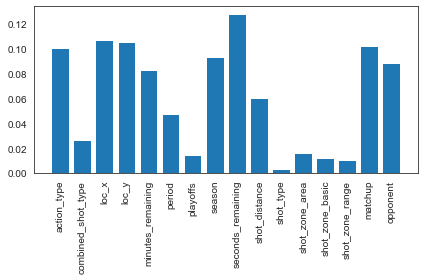

In [24]:
plt.bar(range(16), attribute_importance)
plt.xticks(range(16), attribute_names, rotation=90)
plt.tight_layout()
plt.show()

In [25]:
my_scaler = StandardScaler()
attribute_values_std = my_scaler.fit_transform(attribute_values)

In [49]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(attribute_values_std, target_values)

In [50]:
lsvc.coef_

array([[ 0.02047519, -0.13503174,  0.01043324,  0.05970918,  0.01372552,
        -0.02082097,  0.        ,  0.00339255,  0.01802563, -0.30690732,
         0.10692962, -0.02560203,  0.0983395 , -0.04020607,  0.00931687,
         0.00087936]])

In [51]:
coefficient_values = lsvc.coef_.tolist()[0]

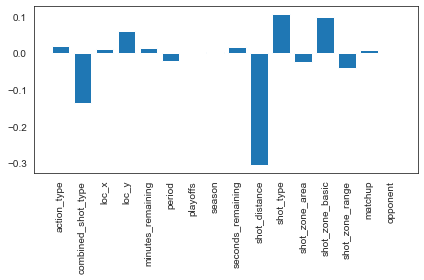

In [52]:
plt.bar(range(16), coefficient_values)
plt.xticks(range(16), attribute_names, rotation=90)
plt.tight_layout()
plt.show()

In [54]:
covariant_matrix = np.cov(attribute_values_std.T)

In [55]:
eigenvalues, eigenvectors = np.linalg.eig(covariant_matrix)

In [56]:
eigenvalues

array([3.70537984, 1.68974734, 1.52122831, 0.04518773, 0.22179863,
       0.10296904, 0.45234976, 0.52348628, 1.1112904 , 0.84390852,
       0.86408245, 0.91520478, 0.95165668, 1.00450004, 1.01446328,
       1.03336959])

In [63]:
pca = PCA(n_components=2)

In [64]:
attribute_values_std_pca = pca.fit_transform(attribute_values_std)

In [65]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier):

    
    cmap = ListedColormap(("red", "blue", "green"))
    
    xx1, xx2 = np.meshgrid(np.arange(X[:,0].min(), X[:,0].max(), (X[:,0].max()-X[:,0].min())/200),
                          np.arange(X[:,1].min(), X[:,1].max(), (X[:,1].max()-X[:,1].min())/200))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, color=cmap(idx),
                   marker="+",label=cl)

In [66]:
my_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(attribute_values_std_pca,
                                                           target_values)

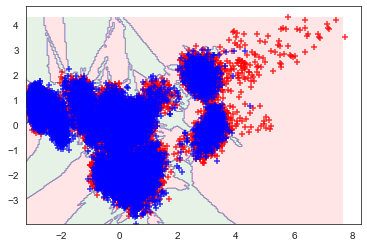

In [67]:
plot_decision_regions(attribute_values_std_pca,
                      target_values,
                      classifier=my_knn)